## Mixed-element Meshing - Toy Problem

This workflow provides a testbed for testing features of mixed-element mesh wotkflow. The objects of river tree and huc boundary are a created to mimic what we get from NHDPlus. This example tests the case of two rivers, which is rare but still needs to be considered to make the workflow general

In [1]:
## Importing all the package needed to run teh watershed workflow

import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging
import pandas as pd
import fiona
import seaborn as sns
import copy
import scipy
from descartes.patch import PolygonPatch

In [2]:
import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.condition
import watershed_workflow.densify_rivers_hucs
watershed_workflow.ui.setup_logging(1,None)
crs=None

In [3]:
## NHDPlus input type objects

# creating watershed polygon
ws1= shapely.geometry.Polygon(100*np.array([[0,0],[1,0],[3,0],[4,0],[4,1],[4,2],[4,3],[4,4],[3,4.5],[2,5],[1,4.5], [0,4], [0,3], [0,2] ,[0,1]], 'd'))

# creating reaches miminc NHDPlus flowlines
reach1=shapely.geometry.LineString([(200,200),(200,0)])
reach2=shapely.geometry.LineString([ (50,300), (100,300), (100,200),(200,200)])
reach3=shapely.geometry.LineString([ (350,400),(350,300),(300,300),(300,200),(200,200)])
reach4=shapely.geometry.LineString([(100,400), (200,300)])
reaches=[reach1, reach2, reach3, reach4]

In [4]:
# creating watershed_workflow.split_hucs.SplitHUCs object for demo watershed
my_hucs=[ws1]
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

In [5]:
rivers = watershed_workflow.construct_rivers(watershed,reaches, method='geometry')

# adding relevant properties
for river in rivers:
    for i, node in enumerate(river.preOrder()):
        node.properties['HydrologicSequence']=i


rivers_orig=[river.deep_copy() for river in rivers] # mimicking the original
watershed_orig=copy.deepcopy(watershed) # keeping the original

# simplify the geometry for a "nicer" discrete object
watershed_workflow.simplify(watershed, rivers, simplify_rivers=10,
                            snap=False, cut_intersections=True)

# processing originals to match structure of river tree as simplified while keeping the high resolution
watershed_workflow.simplify(watershed_orig, rivers_orig, simplify_rivers=0.1,
                            snap=False, cut_intersections=True)

# for plotting purpose
rivers_simplified=[river.deep_copy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2022-04-28 20:35:38,827 - root - INFO: 
2022-04-28 20:35:38,828 - root - INFO: Constructing river network
2022-04-28 20:35:38,829 - root - INFO: ------------------------------
2022-04-28 20:35:38,829 - root - INFO: Generating the river tree
2022-04-28 20:35:38,831 - root - INFO:  ... generated 2 rivers
2022-04-28 20:35:38,833 - root - INFO: 
2022-04-28 20:35:38,834 - root - INFO: Simplifying
2022-04-28 20:35:38,834 - root - INFO: ------------------------------
2022-04-28 20:35:38,835 - root - INFO: Simplifying rivers
2022-04-28 20:35:38,836 - root - INFO: Cutting crossings and removing external segments
2022-04-28 20:35:38,837 - root - INFO:   cutting at crossings
2022-04-28 20:35:38,837 - root - INFO: intersection found
2022-04-28 20:35:38,841 - root - INFO:   - cutting reach at external boundary of HUCs
2022-04-28 20:35:38,842 - root - INFO: 
2022-04-28 20:35:38,843 - root - INFO: Simplification Diagnostics
2022-04-28 20:35:38,843 - root - INFO: ------------------------------
2022-04

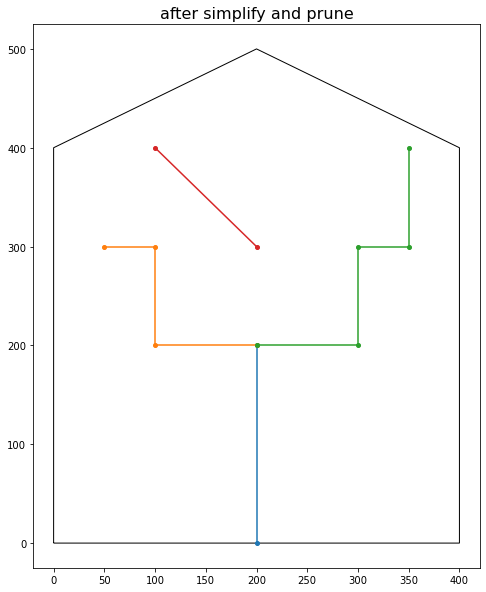

In [6]:
# quick glance at the problem
plt.rcParams['figure.figsize'] = [8, 10]

fig, axs = plt.subplots(1,1)

watershed_workflow.plot.hucs(watershed_simplified, crs, 'k', axs)
axs.set_title('after simplify and prune',fontsize=16)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs.plot(x,y,'-o',markersize=4)
   

In [7]:
#densify watershed
watershed=watershed_workflow.densify_rivers_hucs.densify_hucs(watershed, watershed_orig,river,use_original= False,limit_scales=[0,50,100,50])

#densify river
rivers=watershed_workflow.densify_rivers_hucs.densify_rivers(rivers, rivers_orig, limit=14, use_original=False, treat_collinearity=True)

/Users/7s2/github/ww_ssr_wip/watershed-workflow/watershed_workflow/densify_rivers_hucs.py:237: RuntimeWarning: divide by zero encountered in double_scalars
  m=(p2[1] - p0[1])/(p2[0] - p0[0])


In [8]:
# finding the outlet
watershed_workflow.split_hucs.find_outlets_by_hydroseq(watershed, rivers[0])

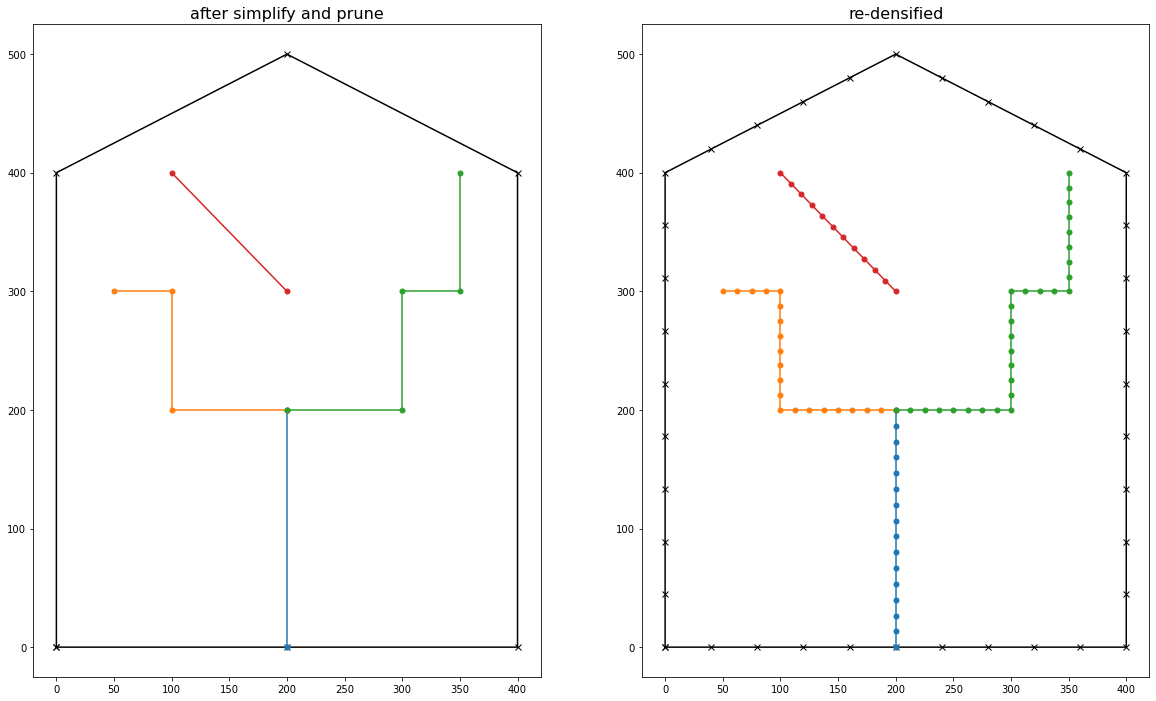

In [9]:
# plotting results
plt.rcParams['figure.figsize'] = [20, 12]

fig, axs = plt.subplots(1,2)

axs[0].plot(watershed_simplified.exterior().exterior.xy[0], watershed_simplified.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('after simplify and prune',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('re-densified',fontsize=16)
axs[1].plot()

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy
        axs[1].plot(x,y,'-o',markersize=5)

# Meshing

In [10]:
## This is a combined function of the above four steps. 
quads, corrs=watershed_workflow.river_tree.create_rivers_meshes(rivers=rivers, widths=5, junction_treatment=True)

for this river [[0, 1, 125, 126], [1, 2, 124, 125], [2, 3, 123, 124], [3, 4, 122, 123], [4, 5, 121, 122], [5, 6, 120, 121], [6, 7, 119, 120], [7, 8, 118, 119], [8, 9, 117, 118], [9, 10, 116, 117], [10, 11, 115, 116], [11, 12, 114, 115], [12, 13, 113, 114], [13, 14, 112, 113], [14, 15, 55, 111, 112], [15, 16, 54, 55], [16, 17, 53, 54], [17, 18, 52, 53], [18, 19, 51, 52], [19, 20, 50, 51], [20, 21, 49, 50], [21, 22, 48, 49], [22, 23, 47, 48], [23, 24, 46, 47], [24, 25, 45, 46], [25, 26, 44, 45], [26, 27, 43, 44], [27, 28, 42, 43], [28, 29, 41, 42], [29, 30, 40, 41], [30, 31, 39, 40], [31, 32, 38, 39], [32, 33, 37, 38], [33, 34, 36, 37], [34, 35, 36], [55, 56, 110, 111], [56, 57, 109, 110], [57, 58, 108, 109], [58, 59, 107, 108], [59, 60, 106, 107], [60, 61, 105, 106], [61, 62, 104, 105], [62, 63, 103, 104], [63, 64, 102, 103], [64, 65, 101, 102], [65, 66, 100, 101], [66, 67, 99, 100], [67, 68, 98, 99], [68, 69, 97, 98], [69, 70, 96, 97], [70, 71, 95, 96], [71, 72, 94, 95], [72, 73, 93, 9

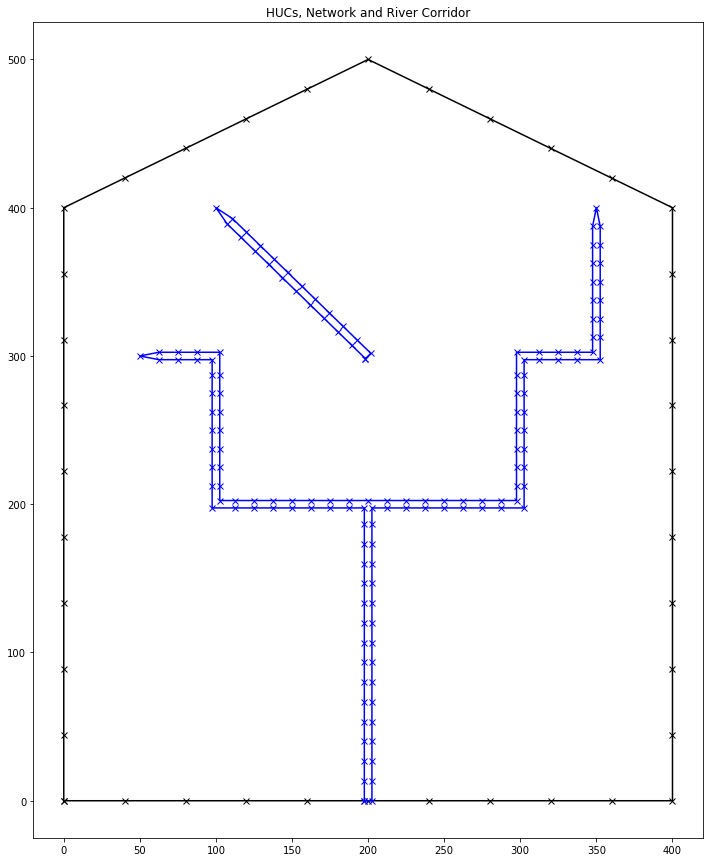

In [11]:
## plotting river corridor and river tree together
fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(111)
ax.plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
for corr in corrs:   
    ax.plot(corr.exterior.xy[0], corr.exterior.xy[1], 'b-x')
plt.title('HUCs, Network and River Corridor')
plt.show()

In [12]:
# triangulating the domain the a hole in rivers with some refinement for the domain closer to the river corridors

refine_d0 = 12
refine_d1 = 18
refine_A0 = 82
refine_A1 = 500
d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

points, elems= watershed_workflow.triangulate(watershed, rivers ,corrs, mesh_rivers=True,
                                              refine_min_angle=32, refine_distance=[d0,A0,d1,A1],
                                              diagnostics=False)

2022-04-28 20:35:41,053 - root - INFO: 
2022-04-28 20:35:41,054 - root - INFO: Meshing
2022-04-28 20:35:41,055 - root - INFO: ------------------------------
2022-04-28 20:35:41,063 - root - INFO: Triangulating...
2022-04-28 20:35:41,064 - root - INFO: Adding river-corridor outlet into huc boundary
2022-04-28 20:35:41,067 - root - INFO:    187 points and 188 facets
2022-04-28 20:35:41,067 - root - INFO:  checking graph consistency
2022-04-28 20:35:41,068 - root - INFO:  tolerance is set to 1
2022-04-28 20:35:41,069 - root - INFO:  building graph data structures
2022-04-28 20:35:41,071 - root - INFO: defining hole..
2022-04-28 20:35:41,073 - root - INFO:  triangle.build...
2022-04-28 20:35:44,268 - root - INFO:   ...built: 703 mesh points and 1219 triangles


maximum area of the traingle 759.140041 , minimum area of the triangle 20.711983 , number of triangles 1219


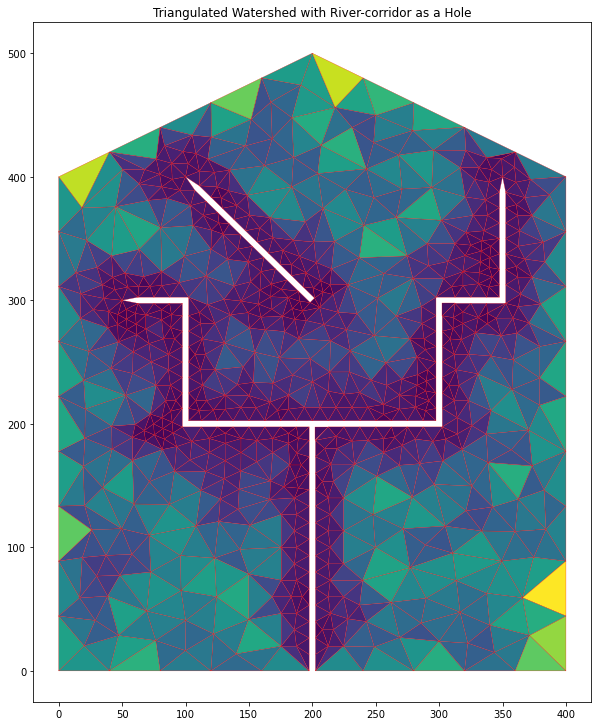

In [13]:
areas = np.array([watershed_workflow.utils.triangle_area(points[e]) for e in elems])
fig = plt.figure(figsize=(12/1.2,15/1.2))
print('maximum area of the traingle', round(max(areas),6) ,', minimum area of the triangle', round(min(areas),6), ', number of triangles', len(areas))
plt.rcParams['figure.figsize'] = [10, 10]
plt.tripcolor(points[:,0], points[:,1], elems, areas, edgecolor='r')
plt.title('Triangulated Watershed with River-corridor as a Hole')
plt.show()

In [14]:
## adding quads to the list of elements
elems_list=[elem.tolist() for elem in list(elems)]
for elem in quads:
    elems_list.append(elem)

In [15]:
# providing elevations to each point of the mesh (real case this would come from DEMs)
points3=np.zeros((len(points),3))
points3[:,:2]=points
points3[:,2]=9+abs(points[:,0]-200)/800+points[:,1]/500 # gradient towards the outlet 

In [16]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(points3.copy(), elems_list)

In [17]:
def condition_river_mesh(m2, river, depress_by):
    m2_copy=copy.deepcopy(m2)
    for node in river.preOrder():
        for i, elem in enumerate(node.elements):
            for j in range(len(elem)):
                m2.coords[elem[j]][2]=m2_copy.coords[elem[j]][2]-depress_by

In [18]:
# adding depressions for the river
for river in rivers:
    condition_river_mesh(m2, river, 1)

kwargs =  {'linewidth': 2, 'cmap': <matplotlib.colors.ListedColormap object at 0x14f8cc340>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x14f8cccd0>, 'linestyle': '-'}
setting face color =  [9.47270926 9.23800495 9.33006593 ... 8.85113644 8.88068137 8.90530283]


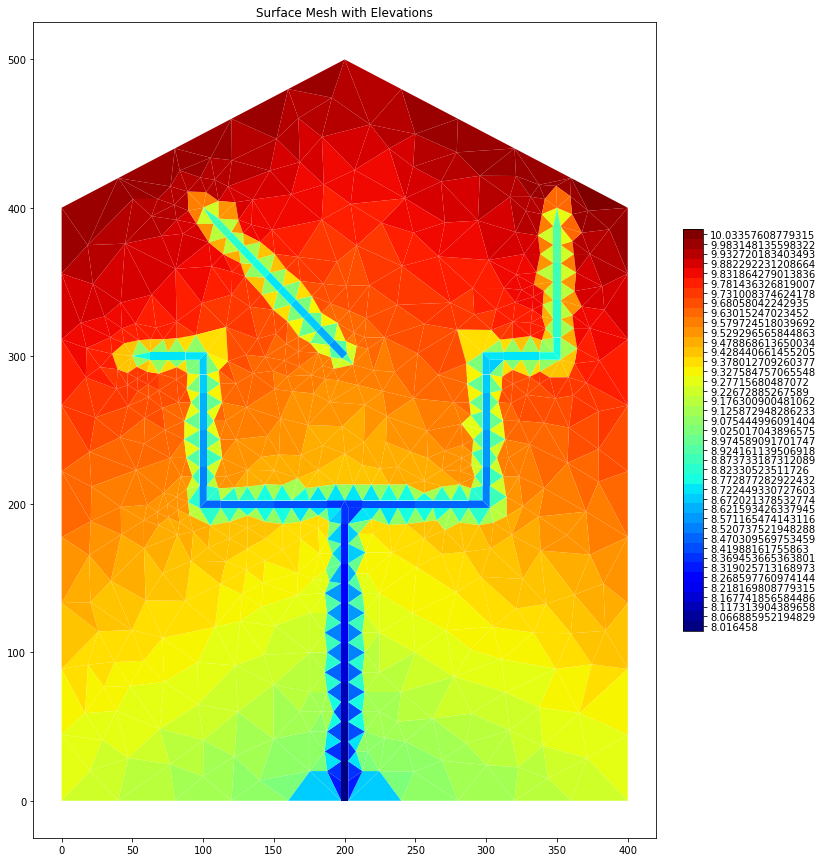

In [19]:
# plotting surface mesh with elevations
plt.rcParams['figure.figsize'] = [12, 15]
crs=None
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')
fig, ax = watershed_workflow.plot.get_ax(crs)

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=2 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, facecolor='color')

watershed_workflow.colors.colorbar_index(ncolors=len(legend_values), cmap=cmap, labels = labels) 
plt.title('Surface Mesh with Elevations')
plt.show()

### Mesh Extrusion

In [20]:
## **** Creating a 3D mesh

# this is oversimplified case where we wille xtrude this mesh in 3D with 10 layers of prescribed thicknesses

total_thickness = 10
dzs=[0.1,0.2, 0.2, 0.25,0.25,0.25,0.25,1,1.25,1.25,2,3]
print(sum(dzs))
assert(sum(dzs)==total_thickness)

# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

depth = 0
for dz in dzs:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1000)
  
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2022-04-28 20:36:41,006 - root - INFO: Cell summary:
2022-04-28 20:36:41,007 - root - INFO: ------------------------------------------------------------
2022-04-28 20:36:41,007 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2022-04-28 20:36:41,008 - root - INFO: ------------------------------------------------------------
2022-04-28 20:36:41,008 - root - INFO:  00 	| 00 	| 1000 	|   0.100000 	|   0.000000
2022-04-28 20:36:41,009 - root - INFO:  01 	| 01 	| 1000 	|   0.200000 	|   0.100000
2022-04-28 20:36:41,009 - root - INFO:  02 	| 02 	| 1000 	|   0.200000 	|   0.300000
2022-04-28 20:36:41,010 - root - INFO:  03 	| 03 	| 1000 	|   0.250000 	|   0.500000
2022-04-28 20:36:41,011 - root - INFO:  04 	| 04 	| 1000 	|   0.250000 	|   0.750000
2022-04-28 20:36:41,011 - root - INFO:  05 	| 05 	| 1000 	|   0.250000 	|   1.000000
2022-04-28 20:36:41,012 - root - INFO:  06 	| 06 	| 1000 	|   0.250000 	|   1.250000
2022-04-28 20:36:41,012 - root - INFO:  07 	| 07 	| 1000 	|   1.000000 	|   1.5

10.0


In [21]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2,layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# saving mesh as exodus file
m3.write_exodus('demo_mixed_element_mesh.exo')

2022-04-28 20:37:26,340 - root - INFO: adding side set: 1
2022-04-28 20:37:26,344 - root - INFO: adding side set: 2
2022-04-28 20:37:26,348 - root - INFO: adding side set: 3



You are using exodus.py v 1.20.10 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: demo_mixed_element_mesh.exo
Closing exodus file: demo_mixed_element_mesh.exo
